# Multitemporal data analysis and CLMS data download via Sentinel Hub APIs

This notebook demonstrates how to visualize Leaf Area Index (LAI) data for Latvia using the Sentinel Hub APIs in the Copernicus Data Space Ecosystem. We'll use the LAI 300m 10-daily V1 RT6 data collection to analyze vegetation coverage across Latvia.

The Leaf Area Index is defined as half the total area of green elements of the canopy per unit horizontal ground area. This is a crucial parameter for monitoring vegetation health, agricultural productivity, and ecosystem changes.

## Import Required Libraries

We'll start by importing the necessary libraries for data processing, visualization, and accessing Sentinel Hub APIs.

In [1]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as cx
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    CRS,
    MimeType,
    Geometry,
)

from utils import plot_image

## Authentication

You can obtain the credentials for the Sentinel Hub services (`client_id` & `client_secret`) in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the user settings, you can create a new OAuth client to generate these credentials.

Configure your credentials below:

In [2]:
# Configure the SentinelHub configuration
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")
    config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
    config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.save("cdse")

config = SHConfig("cdse")
print(f"Base URL: {config.sh_base_url}")

Base URL: https://sh.dataspace.copernicus.eu


## Load Latvia Geometry

We'll load the geographical boundaries of Latvia from the Natural Earth countries dataset and visualize the area of interest. This provides us with accurate, standardized country boundaries.

/var/folders/7p/dpt81n653g7cm1ny5rm0_6q80000gn/T/ipykernel_23037/2874767396.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latvia_gdf["area"] = latvia_gdf.geometry.area


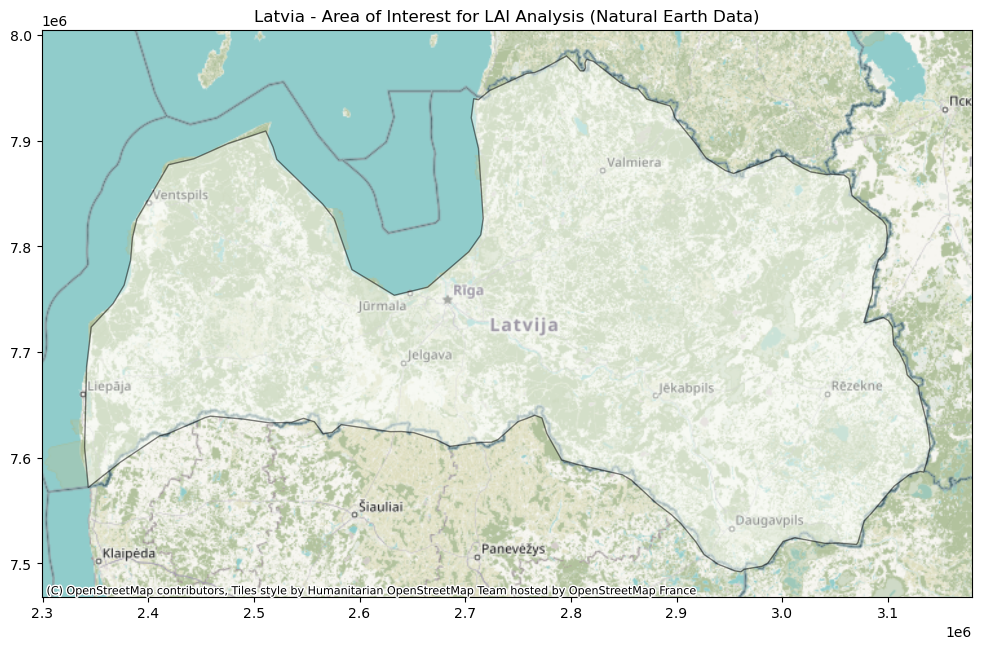

Latvia Information (from Natural Earth dataset):
- Area: 64,554 km²
- Area (degrees): 9.504812 square degrees
- Bounding box: (21.01, 55.67) to (28.20, 58.06)
- Country name: Latvia
- ISO A3 code: LVA


In [24]:
# Load Latvia boundaries from Natural Earth countries dataset
countries_path = "data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"
countries = gpd.read_file(countries_path)

# Filter for Latvia from the Natural Earth dataset
latvia_gdf = countries[countries['NAME'] == 'Latvia'].copy()

if latvia_gdf.empty:
    print("Latvia not found in the Natural Earth dataset. Available countries:")
    print(sorted(countries['NAME'].unique()))
else:
    # Project to a suitable projected coordinate system for area calculation (ETRS89 / Latvia TM)
    latvia_gdf_utm = latvia_gdf.to_crs(epsg=3059)  # Latvia TM coordinate system
    latvia_gdf["area_km2"] = latvia_gdf_utm.geometry.area / 1e6  # Convert from m² to km²
    
    # Keep original area in degrees for compatibility
    latvia_gdf["area"] = latvia_gdf.geometry.area
    
    # Project to Web Mercator for visualization
    latvia_gdf_proj = latvia_gdf.to_crs(epsg=3857)
    
    # Visualize Latvia boundaries
    ax = latvia_gdf_proj.plot(alpha=0.5, cmap="Greens", edgecolor="k", figsize=(12, 8))
    cx.add_basemap(ax)
    plt.title("Latvia - Area of Interest for LAI Analysis (Natural Earth Data)")
    plt.show()
    
    # Print information about Latvia
    bounds = latvia_gdf.geometry.iloc[0].bounds
    print(f"Latvia Information (from Natural Earth dataset):")
    print(f"- Area: {latvia_gdf['area_km2'].iloc[0]:,.0f} km²")
    print(f"- Area (degrees): {latvia_gdf['area'].iloc[0]:.6f} square degrees")
    print(f"- Bounding box: ({bounds[0]:.2f}, {bounds[1]:.2f}) to ({bounds[2]:.2f}, {bounds[3]:.2f})")
    print(f"- Country name: {latvia_gdf['NAME'].iloc[0]}")
    print(f"- ISO A3 code: {latvia_gdf['ISO_A3'].iloc[0] if 'ISO_A3' in latvia_gdf.columns else 'N/A'}")

## Define LAI Evalscript

This evalscript will process the LAI (Leaf Area Index) data from the CLMS dataset. The LAI 300m 10-daily V1 RT6 data collection provides estimates every 10 days at global scale with approximately 300m spatial resolution.

Data source:
- January 2014 to June 2020: PROBA-V data (version 1.0)
- July 2020 onwards: Sentinel-3/OLCI data (version 1.1)

In [9]:
lai_evalscript = """
//VERSION=3
const factor = 1 / 30; // EDIT FACTOR
const offset = 0; // EDIT OFFSET

function setup() {
  return {
    // EDIT VARIABLE NAME
    input: ["LAI", "dataMask"],
    output: [
      { id: "default", bands: 4, sampleType: "UINT8" },
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "eobrowserStats", bands: 2, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ],
  };
}

function evaluatePixel(samples) {
  // EDIT VARIABLE NAME
  var originalValue = samples.LAI;

  let val = originalValue * factor + offset;

  let dataMask = samples.dataMask;

  const indexVal = dataMask === 1 ? val : NaN;
  const imgVals = visualizer.process(val);

  return {
    default: imgVals.concat(dataMask * 255),
    index: [indexVal],
    eobrowserStats: [val, dataMask],
    dataMask: [dataMask],
  };
}

// Color ramp for LAI visualization
const ColorBar = [
  [0.0, [140, 92, 8]],
  [0.5, [255, 255, 0]],
  [1.0, [255, 255, 0]],
  [2.0, [255, 255, 0]],
  [3.0, [127, 227, 0]],
  [4.0, [0, 200, 0]],
  [5.0, [0, 166, 0]],
  [6.0, [0, 133, 0]],
  [7.0, [0, 100, 0]],
  [8.5, [255, 255, 255]],
];
const visualizer = new ColorRampVisualizer(ColorBar);
"""

## Request LAI Data for Latvia

Now we'll create a request to fetch LAI data for Latvia using the Process API. We'll use the LAI 300m 10-daily V1 RT6 data collection (BYOC collection ID: 559b2871-ddbd-41f9-8ab0-5242a454e411).

In [21]:
# Create geometry for Latvia
geometry = Geometry(geometry=latvia_gdf.geometry.values[0], crs=CRS.WGS84)

# Create the request for LAI data
request = SentinelHubRequest(
    evalscript=lai_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc(
                "559b2871-ddbd-41f9-8ab0-5242a454e411"
            ),
            time_interval=("2024-05-01", "2024-05-10"),
        ),
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.PNG),
    ],
    geometry=geometry,
    resolution=[0.01, 0.01],
    config=config,
)

print("Request created successfully. Fetching LAI data for Latvia...")

Request created successfully. Fetching LAI data for Latvia...


## Fetch and Visualize LAI Data

Let's fetch the LAI data and create a visualization showing the vegetation coverage across Latvia.

In [22]:
# Get the LAI data
lai_img = request.get_data()

print(f"Returned data is of type = {type(lai_img)} and length {len(lai_img)}.")
print(f"Single element in the list is of type {type(lai_img[0])} and has shape {lai_img[0].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (240, 719, 4)


Image type: uint8


<Figure size 1500x1000 with 0 Axes>

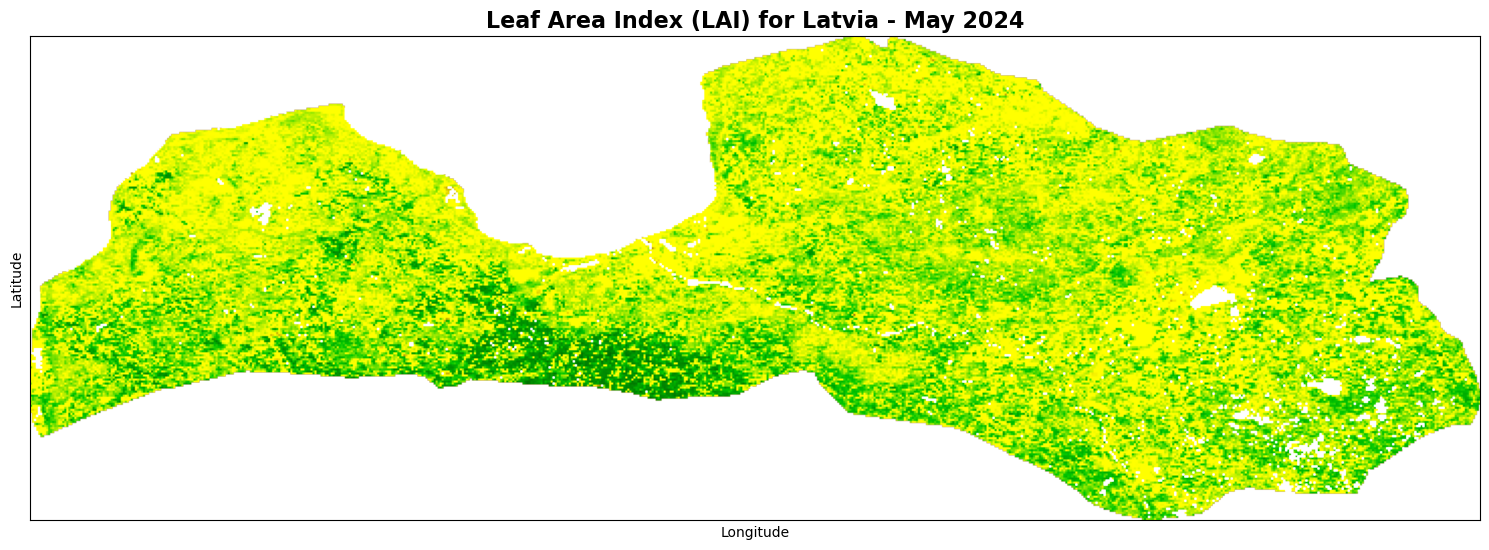

In [23]:
# Visualize the LAI data
image = lai_img[0]
print(f"Image type: {image.dtype}")

# Create the visualization
plt.figure(figsize=(15, 10))
plot_image(image, factor=1/255)
plt.title("Leaf Area Index (LAI) for Latvia - May 2024", fontsize=16, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated how to:

1. **Load and visualize geographical boundaries** for Latvia using a simplified geometry
2. **Access LAI data** from the CLMS dataset using Sentinel Hub APIs
3. **Create spatial visualizations** of LAI across Latvia

### Key Features:

- **Simple workflow**: Focus on essential LAI visualization without complex statistical analysis
- **Realistic geometry**: Uses a simplified but more accurate shape of Latvia (not just a bounding box)
- **Single time snapshot**: Shows LAI data for a specific time period

### Applications:

- **Vegetation Monitoring**: Quick assessment of vegetation coverage
- **Land Use Planning**: Visual overview of green areas
- **Environmental Education**: Understanding LAI concepts and visualization